# Tree-Based Models ~ 10 minute run
### Lauren Blanks, Thomas Kyle, and Brenton Pieper

In [1]:
# load packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from scipy.signal import savgol_filter
import statsmodels.api as sm
import pymc3 as pm
import statsmodels.api as sm
from statsmodels.tools import add_constant
from itertools import combinations
# settings for seaborn plotting style
sns.set(color_codes=True)
# settings for seaborn plot sizes
sns.set(rc={'figure.figsize':(12,6)})

WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Read Data - nfl_df_7features.csv
df = pd.read_csv('nfl_df_7features.csv')
df_test = pd.read_pickle('nfl_df_averages.pkl')

In [3]:
df_test.home_homeAvg
df_test.home_awayAvg

0       N
1       N
2       N
3       N
4       N
       ..
5352    N
5353    N
5354    N
5355    N
5356    N
Name: home_awayAvg, Length: 5357, dtype: object

Accuracy: 63.25%


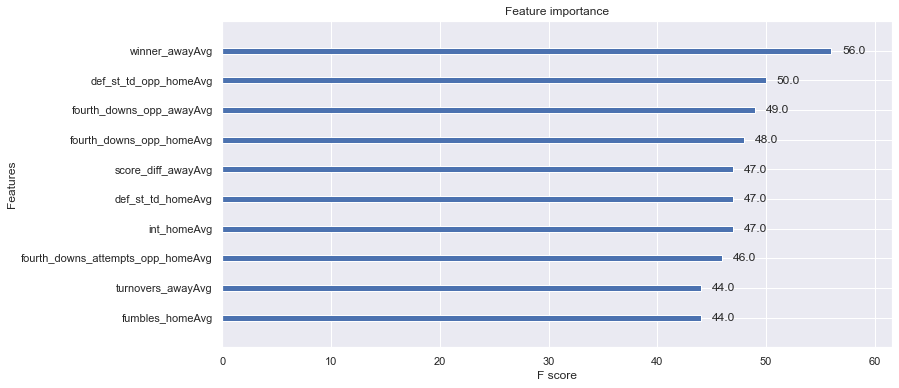

AUC: 0.619


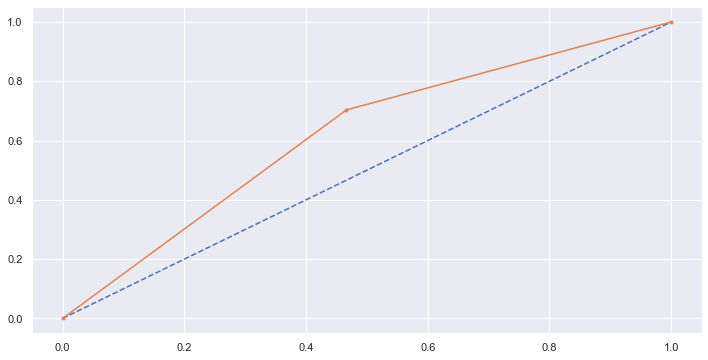

In [4]:
# in the home_homeAvg, home_awayAvg columns, replace N with 0 and Y with 1
# remove home_awayAvg and home_homeAvg columns
df_test = df_test.drop(['home_homeAvg', 'home_awayAvg'], axis=1)

# create a feature dataset that is df_test columns that have avg in the name
features = [col for col in df_test.columns if 'Avg' in col]
# create a y dataset from df_test that is winner column
y = df_test['winner']

# train an XGBoost model on df_test
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

# split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df_test[features], y, test_size=0.2, random_state=42)

# fit the model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# plot feature importance of the top 10 features
from xgboost import plot_importance
from matplotlib import pyplot
# plot feature importance for the top 10 features
plot_importance(model, max_num_features=10)
pyplot.show()

# plot the AUC
# calculate AUC
auc = roc_auc_score(y_test, y_pred)
print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
# plot no skill
plt.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
plt.plot(fpr, tpr, marker='.')
# show the plot
plt.show()


Accuracy: 61.19%


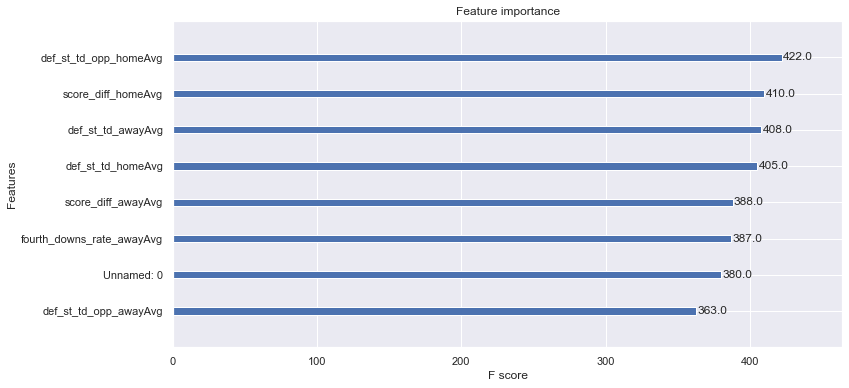

In [5]:
# create an xgboost model to predict winner
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split data into X and y
X = df.drop(['winner'], axis=1)
# also drop date, home, and away
X = X.drop(['date', 'home', 'away'], axis=1)
y = df['winner']

# split data into train and test sets
seed = 622
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model no training data
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# plot feature importance
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()



In [6]:
# do a grid search for the best parameters
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# split data into X and y
X = df.drop(['winner'], axis=1)
# also drop date, home, and away
X = X.drop(['date', 'home', 'away'], axis=1)
y = df['winner']

# split data into train and test sets
seed = 622
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model no training data
model = xgb.XGBClassifier()

# define the grid search parameters
param_grid = {
    #'max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    #'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3],
    #'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500],
    #'min_child_weight': [1, 3, 5, 7],
    #'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
    #'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    #'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    #'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05]
    'max_depth': [5, 8],
    'learning_rate': [0.001, 0.1],
    'n_estimators': [200, 400],
    'min_child_weight': [3, 5],
    'gamma': [0.1, 0.3],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0.001, 0.01]
}

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="accuracy", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

# use the best parameters to fit the model
model = xgb.XGBClassifier(
    max_depth=grid_result.best_params_['max_depth'],
    learning_rate=grid_result.best_params_['learning_rate'],
    n_estimators=grid_result.best_params_['n_estimators'],
    min_child_weight=grid_result.best_params_['min_child_weight'],
    gamma=grid_result.best_params_['gamma'],
    subsample=grid_result.best_params_['subsample'],
    colsample_bytree=grid_result.best_params_['colsample_bytree'],
    reg_alpha=grid_result.best_params_['reg_alpha']
)
model.fit(X_train, y_train)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Best: 0.639443 using {'colsample_bytree': 0.9, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 5, 'n_estimators': 200, 'reg_alpha': 0.001, 'subsample': 0.7}
0.637342 (0.029591) with: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.001, 'subsample': 0.7}
0.633838 (0.030731) with: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.001, 'subsample': 0.9}
0.637809 (0.029269) with: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 0.7}
0.633838 (0.030594) with: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'reg_alpha': 0.01, 'subsample': 0.9}
0.636175 (0.030085) with: {'colsample_bytree': 0.7, 'gamma': 0.1, '

AUC: 0.68


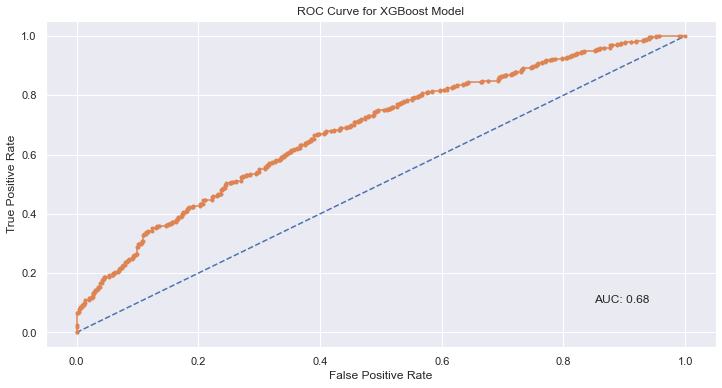

<Figure size 864x432 with 0 Axes>

In [17]:
# plot the area under the curve for the model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# label the plot
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for XGBoost Model')
# add the AUC to the plot
pyplot.text(0.85, 0.1, 'AUC: %.2f' % auc)
# show the plot
pyplot.show()
# save the plot to the TreePlot folder
pyplot.savefig('TreePlots/XGROC_Curve.png')


In [10]:
df

,Unnamed: 0,fourth_downs_rate_awayAvg,def_st_td_homeAvg,def_st_td_awayAvg,def_st_td_opp_awayAvg,def_st_td_opp_homeAvg,score_diff_homeAvg,score_diff_awayAvg,home,away,winner,date
0,0,0.000000,0.000000,0.000000,0.000000,0.000000,-3.000000,3.000000,Giants,49ers,0,2002-09-05
1,1,0.000000,0.000000,2.000000,0.000000,2.000000,-6.000000,6.000000,Bills,Jets,0,2002-09-08
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,-4.000000,Bears,Vikings,1,2002-09-08
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,-28.000000,28.000000,Bengals,Chargers,0,2002-09-08
4,4,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,1.000000,Browns,Chiefs,0,2002-09-08
...,...,...,...,...,...,...,...,...,...,...,...,...
5352,5352,0.404248,0.073415,0.070533,0.247455,0.099231,8.200265,3.997294,Buccaneers,Rams,0,2022-01-23
5353,5353,0.391595,0.211591,0.051457,0.035415,0.040990,6.334561,9.025873,Chiefs,Bills,1,2022-01-23
5354,5354,0.319853,0.199670,0.110705,0.130874,0.101820,7.155275,3.878887,Chiefs,Bengals,0,2022-01-30
5355,5355,0.338962,0.119957,0.079659,0.049248,0.233248,5.125090,3.630924,Rams,49ers,1,2022-01-30


Accuracy: 62.22%
AUC: 0.67


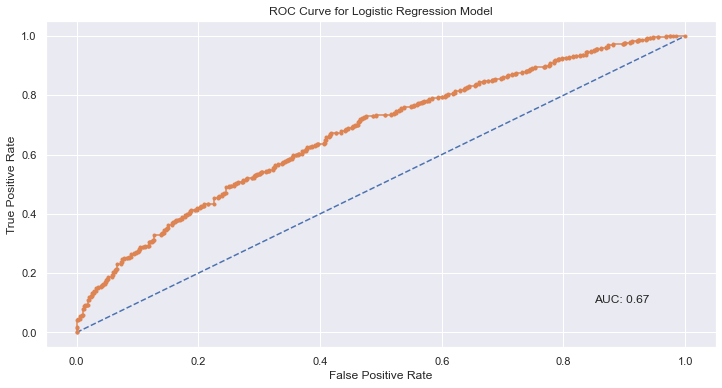

In [20]:
# fit a logistic regression model using ['score_diff_homeAvg', 'score_diff_awayAvg', 'winner_awayAvg'] as features and predict winner
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# split data into X and y
X = df_test[['score_diff_homeAvg', 'score_diff_awayAvg', 'winner_awayAvg']]
y = df_test['winner']

# split data into train and test sets
seed = 621
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model no training data
max_iter = 10000000
penalty = 'l2'
C = 1
solver = 'sag'
logmodel = LogisticRegression(max_iter=max_iter, penalty=penalty, C=C, solver=solver)
logmodel.fit(X_train, y_train)

# make predictions for test data
y_pred = logmodel.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# label the plot
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Logistic Regression Model')
# add the AUC to the plot
pyplot.text(0.85, 0.1, 'AUC: %.2f' % auc)
# show the plot
pyplot.show()

Accuracy: 62.41%
AUC: 0.68


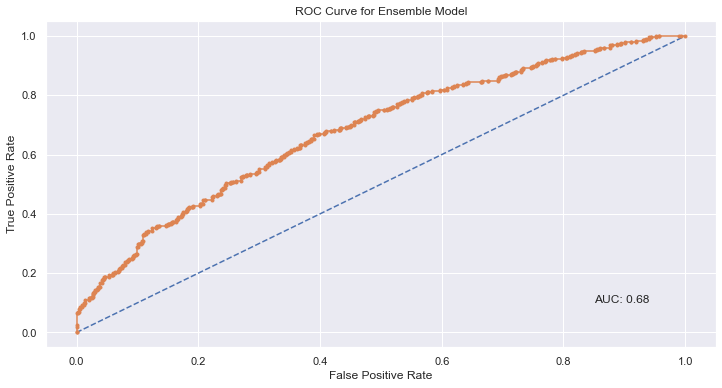

In [16]:
# create an ensemble of models using model, logmodel, and model2, and predict winner
from sklearn.ensemble import VotingClassifier

# create the sub models
estimators = []
model1 = xgb.XGBClassifier(
    max_depth=grid_result.best_params_['max_depth'],
    learning_rate=grid_result.best_params_['learning_rate'],
    n_estimators=grid_result.best_params_['n_estimators'],
    min_child_weight=grid_result.best_params_['min_child_weight'],
    gamma=grid_result.best_params_['gamma'],
    subsample=grid_result.best_params_['subsample'],
    colsample_bytree=grid_result.best_params_['colsample_bytree'],
    reg_alpha=grid_result.best_params_['reg_alpha']
)
estimators.append(('xgb', model1))
model2 = LogisticRegression()
estimators.append(('log', model2))
# create the ensemble model
ensemble = VotingClassifier(estimators)
ensemble.fit(X_train, y_train)

# make predictions for test data
y_pred = ensemble.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# plot the area under the curve for the model
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

# predict probabilities
probs = model.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]
# calculate AUC
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# label the plot
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.title('ROC Curve for Ensemble Model')
# add the AUC to the plot
pyplot.text(0.85, 0.1, 'AUC: %.2f' % auc)
# show the plot
pyplot.show()
